In [0]:
import torch
import time
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import plotly.offline as pyo
import plotly.graph_objs as go
import seaborn as sns
import pandas as pd

import PIL.ImageOps
import requests
from PIL import Image

## IMAGE TRANSFORMATION AND DATALOADER

In [3]:
transform_train = transforms.Compose([transforms.Resize((28,28)),
                                      #torchvision.transforms.CenterCrop(16),
                                       transforms.RandomCrop(28),
                                      #torchvision.transforms.RandomPerspective(),
                                      #transforms.RandomHorizontalFlip(p=0.5),
                                      #transforms.RandomRotation(10),
                                      #transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                               ])
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=128, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 10000, shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# TEST TRANSFORM

In [0]:
test_transform = transforms.Compose([
  # torchvision.transforms.ColorJitter(
  #     brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
  #transforms.RandomRotation((10)), 
  transforms.Resize((28,28)),
  #transforms.RandomCrop(28, padding=4),
  transforms.CenterCrop(28),
  torchvision.transforms.RandomHorizontalFlip(p=0.5),
  #transforms.RandomRotation(degrees=15),
  #torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
  # torchvision.transforms.RandomPerspective(),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))                                            
])

<class 'PIL.JpegImagePlugin.JpegImageFile'>


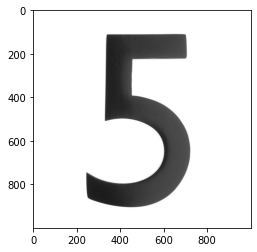

In [36]:
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
print(type(img))
plt.imshow(img)


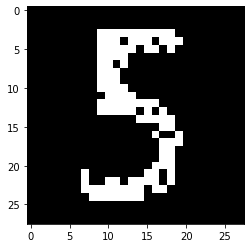

In [37]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = test_transform(img) 
plt.imshow(convert_images(img))


In [7]:
training_loader

In [8]:
training_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [9]:
training_dataset.data.shape

torch.Size([60000, 28, 28])

In [10]:
training_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [11]:
dataiter = iter(training_loader)
inputs, targets = dataiter.next()
inputs.shape

torch.Size([128, 1, 28, 28])

In [12]:
targets.shape

torch.Size([128])

In [13]:
print(type(inputs))
print(type(targets))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


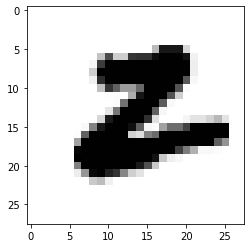

In [14]:
plt.imshow(inputs.detach().numpy()[0].reshape(28,28), cmap='Greys')

## TENSOR TO IMAGE CONVERSION

In [0]:
def convert_image(imagetensor):
  print(f'imagetensor {imagetensor.shape}')
  tensor2array = imagetensor.clone().detach().numpy()
  print(f' type tensor2array {type(tensor2array)}')
  print((f' tensor2array shape {tensor2array.shape}'))
  tensor2array = tensor2array.transpose(2,1,0)
  tensor2array = tensor2array * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  print(f'transposed array {tensor2array.shape}')
  return tensor2array.clip(0,1)

imagetensor torch.Size([1, 28, 28])
 type tensor2array <class 'numpy.ndarray'>
 tensor2array shape (1, 28, 28)
transposed array (28, 28, 3)


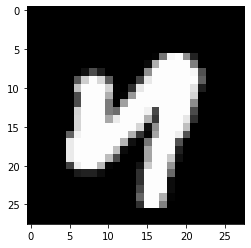

In [16]:
plt.imshow(convert_image(inputs[0]))

In [0]:
def convert_images(imagetensor):
  #print(f'imagetensor {imagetensor.shape}')
  tensor2array = imagetensor.clone().detach().numpy()
  tensor2array = tensor2array.transpose(1,2,0)
  #print(f' type tensor2array {type(tensor2array)}')
  #print((f' tensor2array shape {tensor2array.shape}'))
  tensor2array = tensor2array * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  #print(f'transposed array {tensor2array.shape}')
  return tensor2array.clip(0,1)

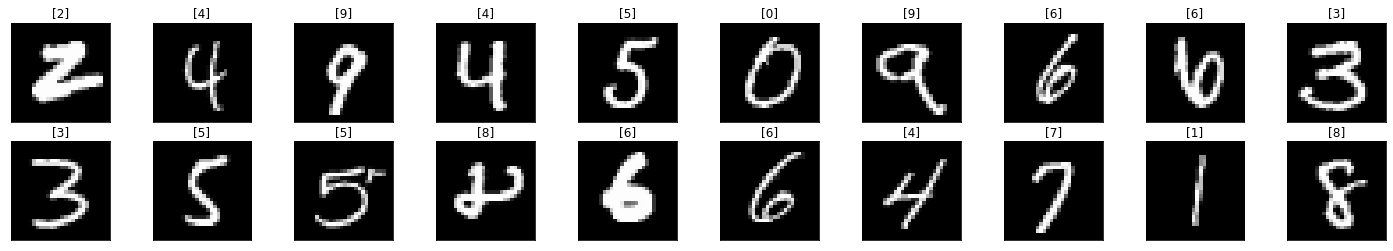

In [18]:
fig = plt.figure(figsize=(25,4))
count=0
for i in range(20):
  ax= fig.add_subplot(2,10,i+1, xticks=[], yticks=[])
  plt.imshow(convert_images(inputs[i]), cmap='Greys')
  ax.set_title([targets[i].item()])

## GPU CONFIGURATION

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## MODEL ARCHITECTURE

In [0]:
class Classifier(nn.Module):
    
    def __init__(self, D_in, M1, M2, K):
        super().__init__()
        self.linear1 = nn.Linear(D_in, M1)
        self.linear2 = nn.Linear(M1, M2)
        self.linear3 = nn.Linear(M2, K)
    def forward(self, x):
        x = F.relu(self.linear1(x))  
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [21]:
model = Classifier(784,64,64,10)
print(device)
model.to(device)

cuda:0


Classifier(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [22]:
model.parameters()

<generator object Module.parameters at 0x7f925f377d00>

# COUNTING PARAMETERS

In [23]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
count_parameters(model)

 50176
    64
  4096
    64
   640
    10
______
 55050


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## MODEL TRAINING

In [25]:
start_time = time.time()
epochs = 10
running_loss_history=[]
running_corrects_history = []
validation_loss_history =[]
valiation_corrects_history =[]

for i in range(epochs):
  
  ###TRAINING
  running_loss = []
  running_total=[]
  val_running_total=[]
  running_corrects = []
  val_running_loss = []
  val_running_corrects = []
  count=0
  for images, target in training_loader:
    t0 = time.time()
    images= images.to(device)
    target= target.to(device)
    images = images.view(images.shape[0],-1)
    
    optimizer.zero_grad()
    
    ###just to print the shapes and more
    if count==0 and i==0: 
     print(f'Inputs are reshaped to NXD {images.shape}')
     print(f'Target are in the shape of N {target.shape}')
     print(target)
    ##predictions

    predictions = model(images)
    if count==0 and i==0: 
     print(f'Predictions shape NXK {predictions.shape}')
     

    ##Analyzing the output
    _,index = torch.max(predictions,1)
    if count==0 and i==0: 
      print(f'Predicted lables for each of the N images {index.shape}')
      print(f'Predicted lables for each of the N images {index}')
      count+=1
    
    loss = criterion(predictions, target)
    running_loss.append(loss.item())
    # Backward and optimize
    loss.backward()
    optimizer.step()


    #train accuracy
    correct= torch.sum(index == target).item()
    train_batch_total = len(target)
    running_corrects.append(correct)
    running_total.append(len(target))
    #running_corrects_history.append(correct/len(target))

 
  train_loss= np.mean(running_loss)
  train_accuracy= np.mean(running_corrects)/np.mean(running_total)
  running_corrects_history.append(train_accuracy)
  running_loss_history.append(train_loss)

  ###VALIDATION 
  count=0
  for val_inputs, val_targets in validation_loader:
    val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
    if count==0 and i==0: 
     print(f'Validation Inputs are reshaped to NXD {val_inputs.shape}')
     print(f'Validation Target are in the shape of N {val_targets.shape}')
     count+=1
    val_inputs=val_inputs.view(val_inputs.shape[0],-1)
    val_preds = model(val_inputs)
    
    ##forward pass
    val_loss = criterion(val_preds, val_targets)
    val_running_loss.append(val_loss.item())
    
    #validation predictions
    _, predictions = torch.max(val_preds,1 )
                               
    val_correct = torch.sum(predictions == val_targets).item()
    val_running_corrects.append(val_correct)
    val_running_total.append(len(val_targets))
    

  val_loss= np.mean(val_running_loss)
  val_accuracy= np.mean(val_running_corrects)/np.mean(val_running_total)
  validation_loss_history.append(val_loss)
  valiation_corrects_history.append(val_accuracy)
  
  
  
  
  print(f'Epoch {i}  {time.time() - t0:.0f} s batch: {np.mean(running_total)}  Train_loss: {train_loss:.4f} Train_acc: {train_accuracy:.4f} val_loss: {val_loss:.4f} val_accuracy: {val_accuracy:.4f}')
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed   

Inputs are reshaped to NXD torch.Size([128, 784])
Target are in the shape of N torch.Size([128])
tensor([9, 5, 8, 7, 3, 1, 5, 5, 2, 9, 1, 4, 5, 7, 2, 9, 4, 7, 2, 1, 5, 3, 1, 1,
        9, 9, 6, 2, 7, 9, 1, 4, 2, 1, 9, 1, 3, 6, 8, 0, 2, 3, 8, 4, 1, 7, 6, 9,
        7, 5, 9, 3, 5, 7, 1, 7, 2, 6, 1, 9, 0, 0, 5, 4, 1, 0, 6, 0, 0, 2, 9, 0,
        3, 5, 6, 4, 2, 2, 4, 2, 5, 6, 9, 1, 1, 8, 7, 3, 2, 0, 7, 4, 2, 2, 6, 7,
        2, 7, 7, 7, 1, 2, 0, 9, 9, 6, 2, 3, 7, 8, 4, 2, 6, 7, 1, 3, 0, 5, 0, 1,
        7, 6, 9, 9, 4, 0, 2, 4], device='cuda:0')
Predictions shape NXK torch.Size([128, 10])
Predicted lables for each of the N images torch.Size([128])
Predicted lables for each of the N images tensor([6, 9, 9, 6, 7, 9, 6, 9, 9, 9, 6, 9, 9, 6, 9, 9, 9, 7, 9, 9, 9, 6, 6, 6,
        9, 9, 9, 9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 6, 7, 9, 9, 6, 9, 9, 6, 6, 7,
        9, 9, 9, 9, 9, 7, 9, 7, 9, 6, 6, 9, 9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6, 9, 6, 9, 9, 9, 9, 9, 9,

In [26]:
traces = [go.Scatter(
    y = np.asarray(losses),
    mode = 'lines',
    name = name   
) for losses, name in zip([running_loss_history,validation_loss_history],['train_loss','val_loss'])]

layout = go.Layout(
    width=800, height=600,
    title = 'Train and Validation Losses'
)

fig = go.Figure(data=traces,layout=layout)

fig.show()

# PREPARING NEW IMAGES TO TEST THE **MODEL**

<class 'PIL.JpegImagePlugin.JpegImageFile'>


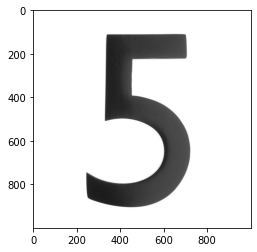

In [27]:
url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
print(type(img))
plt.imshow(img)

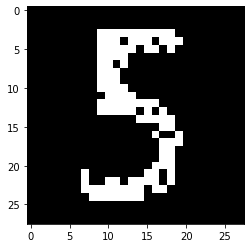

In [28]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(convert_images(img))


In [29]:
img = img.view(img.shape[0], -1)
img = img.to(device)
output = model(img)
_, pred = torch.max(output, 1)
print(f' Predicted Answer {pred.item()}')

 Predicted Answer 5


torch.Size([10000, 1, 28, 28])
torch.Size([10000])
tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')


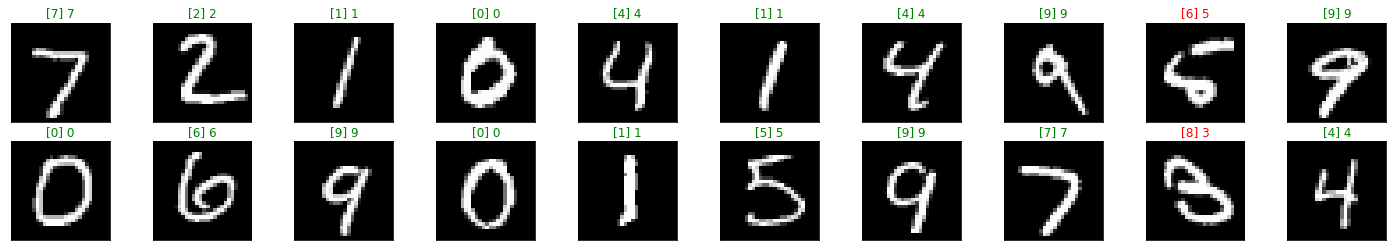

In [30]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
print(images.shape)
model = model.to(device)

images_ = images.view(images.shape[0],-1)
images_ = images_.to(device)
output = model(images_)
_, preds = torch.max(output, 1)
print(preds.shape)
print(preds)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2,10, idx+1, xticks=[], yticks=[])
  plt.imshow(convert_images(images[idx]))
  ax.set_title(f'[{str(preds[idx].item())}] {str(labels[idx].item())}', color= ("green" if preds[idx]==labels[idx] else 'red'))

# CONFUSION MATRIX 

In [31]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))
from sklearn.metrics import confusion_matrix
import pandas as pd
print(f'{np.arange(0,10)}')
arr= confusion_matrix(preds.cpu().view(-1), labels.view(-1))
print(arr)

[    0     1     2     3     4     5     6     7     8     9]
[[  965     0     3     0     0     4     4     2     4     3]
 [    0  1120     0     0     0     1     3    10     0     4]
 [    3     3  1007    12     3     0     1    19     4     0]
 [    1     2     4   973     0     9     0     3     3     9]
 [    1     0     1     0   965     4     6     7     2    22]
 [    2     1     0     3     1   843     4     0     2     1]
 [    3     6     6     0     6     9   936     0     4     2]
 [    0     0     4     5     1     1     0   964     3     4]
 [    2     3     7    16     1    15     4     4   950     8]
 [    3     0     0     1     5     6     0    19     2   956]]


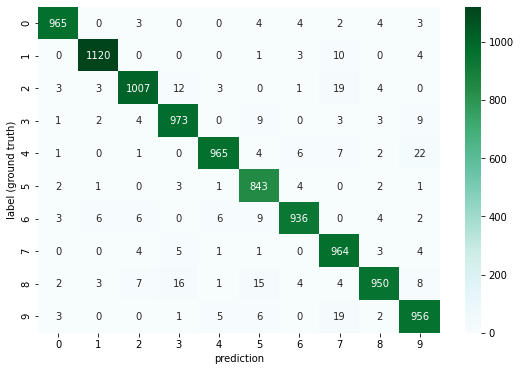

In [32]:
class_names= [str(i) for i in np.arange(0,10)]
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## SAVING THE MODEL

In [0]:
torch.save(model.state_dict(), 'MNIST-ANN.pt')

In [34]:
model2 = Classifier(784,64,64,10)
model2.load_state_dict(torch.load('MNIST-ANN.pt'))
model2.eval()

Classifier(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

# EVALUATING THE TEST LOADED MODEL

In [45]:
test_load_all = DataLoader(validation_dataset, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model2(X_test.view(X_test.shape[0],-1))
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(validation_dataset)} = {correct.item()*100/(len(validation_dataset)):7.3f}%')

Test accuracy: 9679/10000 =  96.790%
